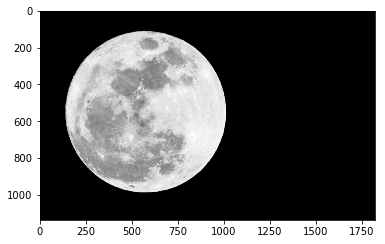

In [45]:
## Imports libs, loads and displays a moon image.

import numpy as np
from scipy import stats
from scipy.ndimage import filters
import matplotlib.pyplot as plt
from matplotlib.cm import gray
from matplotlib import patches
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import convolve

moon = Image.open('assets/moon.jpg')
arr = np.asarray(moon.getdata())
arr = 255 * (arr - arr.min()) / (arr.max() - arr.min())
arr = arr.astype(np.uint8)
moon = arr.reshape((moon.size[1], moon.size[0], 3))

moon_gray = .21 * moon[:, :, 0] + .72 * moon[:, :, 1] + .07 * moon[:, :, 2]
moon_gray = gaussian_filter(moon_gray, 1) #in order to reduce the noise. The higher the parameter the higher blurry it is.

plt.imshow(moon_gray, interpolation='none', cmap=gray)
plt.show()

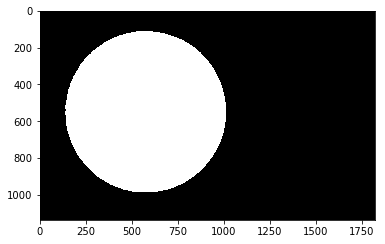

In [52]:
## Thresholds the image to make it binary

moon_thresh = moon_gray>100

####

plt.imshow(moon_thresh, interpolation='none', cmap=gray)
plt.show()

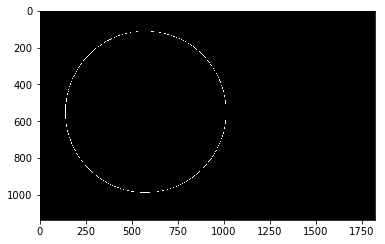

In [53]:
## Extracts the moon edges with a Sobel filter 

#### COMPLETE

kernel_x, kernel_y = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]), np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
Gx, Gy = convolve(moon_thresh, kernel_x),convolve(moon_thresh,kernel_y)
moon_contours = np.sqrt(Gx**2 + Gy**2)

####

plt.imshow(moon_contours.astype(float), interpolation='none', cmap=gray)
plt.show()

In [57]:
## Defines the error metric : the sum of the distances between the points and the modeled circle
## Return distance error
def distance_to_circle(circle_params, points):
    x=points[:,0]
    y=points[:,1]

    x0, y0, R = circle_params[0], circle_params[1], circle_params[2]

    return np.absolute(np.sqrt((x-x0)**2 +(y-y0)**2 - R))

In [ ]:
## Defines the RANSAC function

def circle_ransac(points, nb_it, max_error):
    it = 0
    best_model = []
    best_points = []
    best_error = 1e26

    while it < nb_it:
        ongoing = 100. * (it+1) / nb_it
        if np.remainder(ongoing, 10) == 0:
            print(f'RANSAC : {int(ongoing)} %')
        # Initialization that refuses 3 aligned points, or any line parallel to an axis
        AB, AC = np.array([1, 1]), np.array([1, 1])
        bad_line = True
        while (AB[1] / AC[1] == AB[0] / AC[0]) or bad_line:
            # mix indexes
            index_ = np.random.permutation(points.shape[0])
            # get random samples
            A = points[index_[1], :]
            B = points[index_[2], :]
            C = points[index_[3], :]
            AB = B - A
            AC = C - A
            if A[1] != B[1] and A[0] != B[0] and A[1] != C[1] and A[0] != C[0]:
                bad_line = False

        # Get circle
        # middle m_AB A_B
        m_AB = (B + A) / 2
        m_AC = (A + C) / 2

        # slopes of the mediatrices
        #slope_med_AB = ...
        #slope_med_AC = ...
        slope_med_AB, origin_med_AB = stats.linregress(A,B)
        slope_med_AC, origin_med_AC = stats.linregress(A,C)

        # y axis origin of the mediatrices
        #origin_med_AB = ...
        #origin_med_AC = ...

        # first coordinate of the circle center
        x_c = ...

        circle_center = (x_c, ...)

        circle_radius = ...

        # Compute error
        distances = distance_to_circle((circle_center[0], circle_center[1], circle_radius), points)
        error = ... # Number of points outside the circle (outliers)

        # Check error
        if error < best_error:
          best_error = ...
          best_model = ...
          best_points = (A, B, C)
          inliers = points[np.where(distances <= max_error)[0], :]

        # Save model error and points if best

        it += 1

    return distance_to_circle(best_model, points), best_model


In [ ]:
## Applies RANSAC to the moon edges points

# Get edge points coordinates
edge_points = np.transpose(np.where(moon_contours > 0))

# Apply RANSAC to the set of points
model_error, circle_model = circle_ransac(edge_points, 10000, 2)
print(circle_model)



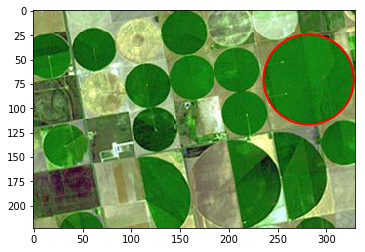

In [183]:
## Displays the results

# Display the model circle on original image
circle = patches.Circle((circle_model[1], circle_model[0]), circle_model[2], fill=False, color='r', linewidth=2)

fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(moon, interpolation='none')
ax.add_patch(circle)
plt.show()



In [160]:
## Optimization approach: objective function definition

from scipy.optimize import fmin

def objective(circle_params):
    max_error = 2
    return np.sum(distance_to_circle((circle_params[0], circle_params[1], circle_params[2]), edge_points) > max_error)

In [176]:
## Optimization approach: minimization

# Initialization
circle_init = [moon.shape[0]*np.random.rand(), 
               moon.shape[1]*np.random.rand(), 
               min([moon.shape[0], moon.shape[1]])*np.random.rand()
              ]
circle_init = [500, 500, 400]

# Optimization
circle_opt = fmin(objective, circle_init, ftol=0)
print(circle_opt)

Optimization terminated successfully.
         Current function value: 6412.000000
         Iterations: 49
         Function evaluations: 133
(array([ 563.74314268,  506.46669682,  371.24335325]), [array([ 500.,  500.,  400.]), array([ 516.66666667,  516.66666667,  380.        ]), array([ 516.66666667,  516.66666667,  380.        ]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 569.44444444,  502.77777778,  366.66666667]), array([ 563.4592

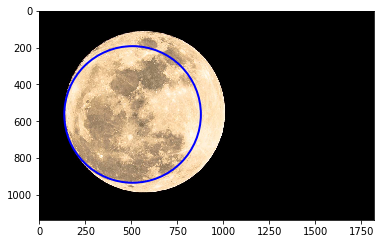

In [168]:
## Optimization approach: displaying results

# Display the model circle on original image
circle_ = patches.Circle((circle_opt[1], circle_opt[0]), circle_opt[2], fill=False, color='b', linewidth=2)

fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(moon, interpolation='none')
ax.add_patch(circle_)
plt.show()